# Preprocessing ratings and textual content for MovieLens datasets

Here, we follow the procedure as that in:

- CDL (KDD'15)  : Collaborative deep learning for recommender systems
- CRAE (NIPS'16): Collaborative Recurrent Autoencoder: Recommend while Learning to Fill in the Blanks
- CVAE (KDD'17) : Collaborative Variational Autoencoder for Recommender Systems

-  (IJCAI'13) : Collaborative topic regression with social regularization for tag recommendation.
-  (TKDE'15) : Relational collaborative topic regression for recommender systems.

which consists in:

- for each user:
  - randomly select P (1 and 10) items for training, and the rest as test
  - repeat the evaluation five times with different training set for each value of P
  - (TODO) use 5-fold cross-validation to find the optimal hyperparameters of CRAE and the baselines

In [1]:
import datetime
import json
import os
import time
import numpy as np

import sys
reload(sys)  
sys.setdefaultencoding('utf8')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from numpy import log10

import pandas as pd
import scipy.sparse

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from operator import itemgetter
from collections import defaultdict
import csv

import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='Serif')
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
csv.field_size_limit(sys.maxsize)

## First, specify dataset version and input directory

In [2]:
DATASET_ID = 'ml-10m'
DATA_DIR   = '/media/augusto/Data2/Dataset/Preprocess_Dataset'
MIN_RATING = 3 # hence, we only consider ratings > 3

P            = 1
execution_id = 1
seed_P_E     = execution_id
output_dir   = 'pro/P_%s_E_%s' % (P, execution_id)

In [3]:
np.random.seed(0)

## Filtering content data

### Here we identify movies:

- with title and plot empty content

In [4]:
columns      = ['description','title', 'views', 'ownerId', 'id', 'tags','favorites']
content_data = pd.read_csv(os.path.join(DATA_DIR, 'noWhite.csv'),
                           sep=',',
                           header=0,
                           usecols=['id', 'title','description'],
                           engine='python')

In [6]:
content_data.shape

(73146, 3)

In [7]:
content_data.head()

,description,title,id
0,Smile On Saturday @ Seasons Beauty\nHappy Eart...,Rhodies - Happy Earth Day,33390536153
1,A three seed bagel \nsesame\npoppy seed\nsunf...,MacroMondays #Seed,34096811425
2,"No Extra-Terrestrials here, just some broken ...",Alien Ship Crash Landing,33153645404
3,Submitted to Macro Mondays #Glaze\nOne of my M...,He's got that glazed look in his eyes,33798476062
4,7DWF Thursday B&amp;W,Listening To The Song Of The Sea,33491411450


In [8]:
# Checking for missing data
content_data.isnull().sum()

description      0
title          797
id               0
dtype: int64

There are 1059 movies without title and 1081 movies without plot. We are going to drop them from the dataset

In [9]:
content_data = content_data.dropna(axis=0) # axis = 0 means drop lines

In [10]:
content_data.shape

(72349, 3)

In [11]:
content_data.isnull().sum()

description    0
title          0
id             0
dtype: int64

In [12]:
valid_content_movie_ids = pd.unique(content_data['id'])

In [13]:
len(valid_content_movie_ids)

71462

## Filtering rating data

### We drop instances with:

- movies with empty title and plot description
- ratings smaller than MIN_RATING
- users with less than 10 ratings
- items with less than 10 ratings

In [14]:
columns  = ['userID', 'pictureID', 'title']
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), 
                       sep=',',
                       header=0,
                       usecols=['userID', 'pictureID', 'title'],
                       engine='python')

In [15]:
raw_data.head()

,pictureID,userID,title
0,33390536153,135122603@N04,Rhodies - Happy Earth Day
1,33390536153,32953505@N03,Rhodies - Happy Earth Day
2,33390536153,127131866@N08,Rhodies - Happy Earth Day
3,33390536153,139028000@N04,Rhodies - Happy Earth Day
4,33390536153,121022422@N02,Rhodies - Happy Earth Day


In [16]:
raw_data.shape # approx. 1 million ratings

(16361376, 3)

In [17]:
raw_data = raw_data.drop_duplicates(['userID', 'pictureID', 'title'])

In [18]:
raw_data.shape # there are not duplicates

(16057180, 3)

In [19]:
# dropping images with empty content/ Fotos que existem na nossa lista de fotos
raw_data = raw_data[raw_data['pictureID'].isin(valid_content_movie_ids)] 

In [20]:
raw_data.shape

(15747752, 3)

In [21]:
raw_data.isnull().sum()

pictureID    0
userID       0
title        0
dtype: int64

In [22]:
raw_data['pictureID'].describe()

count    1.574775e+07
mean     2.995893e+10
std      6.973462e+09
min      1.142986e+08
25%      2.596810e+10
50%      3.193317e+10
75%      3.523844e+10
max      4.053034e+10
Name: pictureID, dtype: float64

In [23]:
raw_data.shape

(15747752, 3)

In [24]:
raw_data.head(5)

,pictureID,userID,title
0,33390536153,135122603@N04,Rhodies - Happy Earth Day
1,33390536153,32953505@N03,Rhodies - Happy Earth Day
2,33390536153,127131866@N08,Rhodies - Happy Earth Day
3,33390536153,139028000@N04,Rhodies - Happy Earth Day
4,33390536153,121022422@N02,Rhodies - Happy Earth Day


In [25]:
raw_data = raw_data.reindex(np.random.permutation(raw_data.index))

In [26]:
raw_data.head(5)

,pictureID,userID,title
6750749,30876412656,46796205@N05,B E L L A . I N . W O N D E R L A N D
10477481,22847152485,62334645@N06,Twilight in Marsaxlokk
10813957,36342546253,52660724@N05,IMGP0831 Tulips
11322635,34205191082,135134103@N05,To the Forbidden Land and Back series :-D Fram...
3211233,18455218701,88312404@N04,Empire in the forest guard


In [27]:
print raw_data[raw_data.index==663341]

In [28]:
def get_count(data, column):
    rating_count_group_by_column = data[[column]].groupby(column, as_index=False)
    count                        = rating_count_group_by_column.size()
    return count

In [32]:
def filter_triplets(data, min_items_per_user=12, min_ratings_per_item=10):
    # only keep triplets for items rated by at least min_ratings_per_item
    if min_ratings_per_item > 0:
        item_count = get_count(data, 'pictureID')
        data       = data[data['pictureID'].isin(item_count.index[item_count >= min_ratings_per_item])]
    # only keep triplets for users who rated at least min_items_per_user
    # after filtering, a small proportion of the items may have less than min_ratings_per_item
    # TODO: verify this later
    if min_items_per_user > 0:
        user_count = get_count(data, 'userID')
        data       = data[data['userID'].isin(user_count.index[user_count >= min_items_per_user])]       
    # update both user_count and item_count after filtering
    user_count, item_count = get_count(data, 'userID'), get_count(data, 'pictureID')
    return data, user_count, item_count

In [33]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [34]:
raw_data.head()

,pictureID,userID,title
6750749,30876412656,46796205@N05,B E L L A . I N . W O N D E R L A N D
10477481,22847152485,62334645@N06,Twilight in Marsaxlokk
10813957,36342546253,52660724@N05,IMGP0831 Tulips
11322635,34205191082,135134103@N05,To the Forbidden Land and Back series :-D Fram...
3211233,18455218701,88312404@N04,Empire in the forest guard


In [35]:
raw_data.shape

(14847780, 3)

In [36]:
user_activity.head()

userID
100000691@N05    58
100001744@N03    51
100001999@N02    88
100003468@N05    14
100004787@N05    27
dtype: int64

In [37]:
item_popularity.head()

pictureID
183339329      6
267187830      3
322424465    124
368572829     16
381312896     17
dtype: int64

For each value of P (1 and 10), we build different training, validation and testing sets

In [38]:
df = raw_data.copy()

In [39]:
grouped = df.groupby('userID', as_index=False)['pictureID'].agg({'list':(lambda x: list(x))})

In [40]:
grouped.head(5)

,userID,list
0,100000691@N05,"[22822278113, 24390336752, 22796074100, 242843..."
1,100001744@N03,"[16580123553, 16747157523, 19345981623, 166587..."
2,100001999@N02,"[33683882005, 34408178123, 26500495834, 334710..."
3,100003468@N05,"[22822278113, 16421073549, 32677062170, 329323..."
4,100004787@N05,"[22736920693, 16658754708, 13145838443, 160236..."


## Let's plot the distribution of rated items

In [41]:
grouped['rating_frequency'] = [len(grouped[grouped.index==i]['list'].values[0]) for i in range(grouped.shape[0])]

(array([8.0079e+04, 5.0760e+03, 2.0540e+03, 1.1340e+03, 7.2500e+02,
        5.3200e+02, 3.4600e+02, 2.6100e+02, 2.1200e+02, 1.7600e+02,
        1.4600e+02, 1.0900e+02, 7.7000e+01, 6.6000e+01, 5.6000e+01,
        5.7000e+01, 4.7000e+01, 4.1000e+01, 3.3000e+01, 3.4000e+01,
        3.2000e+01, 3.2000e+01, 2.3000e+01, 2.5000e+01, 2.0000e+01,
        9.0000e+00, 1.7000e+01, 1.1000e+01, 1.4000e+01, 6.0000e+00,
        7.0000e+00, 9.0000e+00, 3.0000e+00, 2.0000e+00, 6.0000e+00,
        7.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.00

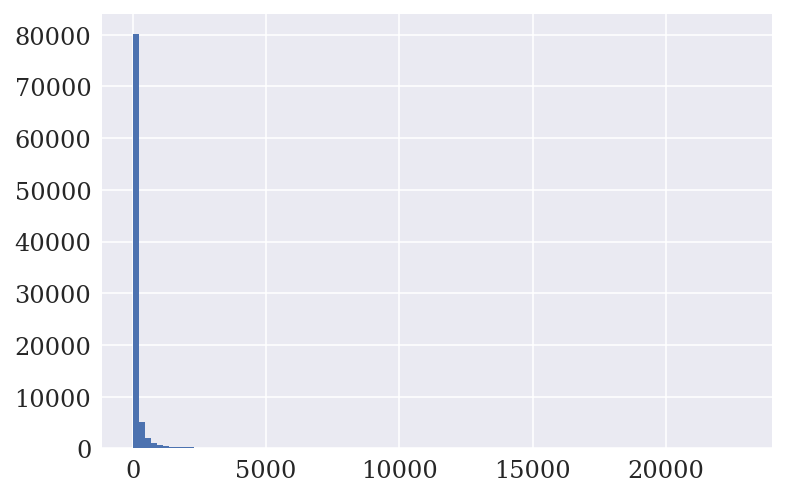

In [44]:
plt.hist(grouped['rating_frequency'],bins=100)
plt.show()

In [46]:
grouped['rating_frequency'].describe()

count    91530.000000
mean       162.217634
std        526.627938
min         12.000000
25%         19.000000
50%         36.000000
75%         97.000000
max      22833.000000
Name: rating_frequency, dtype: float64

In [48]:
num_users_min_ratings = len(grouped[grouped['rating_frequency']==10])


In [49]:
print 'Num users with 10 ratings: %s (%.3f%%)' % (num_users_min_ratings, 100*(float(num_users_min_ratings)/grouped.shape[0]))

In [50]:
grouped=grouped.drop('rating_frequency', axis=1)

## Let's build train/valid/test files

In [51]:
def split_train_val_test(x, train_size, seed):
    np.random.seed(seed)
    train       = np.random.choice(x, [1,train_size], replace=False)[0]
    holdout     = np.array(list(set(x).difference(set(train))))
    num_ratings = len(holdout)
    if num_ratings > 0:
        validation = np.random.choice(num_ratings, size=int(np.ceil(0.10*num_ratings)),replace=False)
        validation_idx = np.zeros(num_ratings, dtype=bool)
        validation_idx[validation] = True
        validation = holdout[validation_idx]
        test = holdout[~validation_idx]
    else:
        validation = np.array([])
        test = np.array([])
    return[train, validation, test]

In [52]:
def get_data(line, pos):
    return line[pos]

In [54]:
def get_split_data_frame(raw_data, grouped_data, label):
    d    = {'train':0, 'val':1, 'test':2}
    fold = grouped_data['splits'].apply(get_data, pos=d[label])
    
    items = fold.values
    users = grouped_data['userID'].values
    
    tmp_list  = map(lambda pair: zip([pair[0]]*len(pair[1]),pair[1]), zip(users, items))
    flat_list = [item for sublist in tmp_list for item in sublist]
    tmp_df    = pd.DataFrame(flat_list,columns=['userID','pictureID'])
    return pd.merge(raw_data, tmp_df)

In [55]:
grouped['splits'] = grouped['list'].apply(split_train_val_test, train_size=P, seed=seed_P_E)

In [56]:
grouped.head()

,userID,list,splits
0,100000691@N05,"[22822278113, 24390336752, 22796074100, 242843...","[[24497962403], [24558368895, 24201688756, 236..."
1,100001744@N03,"[16580123553, 16747157523, 19345981623, 166587...","[[17902740813], [16580123553, 21412232748, 863..."
2,100001999@N02,"[33683882005, 34408178123, 26500495834, 334710...","[[31781575792], [23314346530, 24006309449, 164..."
3,100003468@N05,"[22822278113, 16421073549, 32677062170, 329323...","[[32932308795], [32521986471, 22859497837], [2..."
4,100004787@N05,"[22736920693, 16658754708, 13145838443, 160236...","[[16635615395], [11611317846, 22736920693, 167..."


In [57]:
train_raw_data = get_split_data_frame(raw_data, grouped, 'train')
val_raw_data   = get_split_data_frame(raw_data, grouped, 'val')
test_raw_data  = get_split_data_frame(raw_data, grouped, 'test')

In [58]:
train_raw_data.head()

,pictureID,userID,title
0,39249905754,147849717@N08,Futter
1,32962086760,148869261@N02,Tulipe
2,30021100390,49214499@N06,Neptunbrunnen - Neptune Fountain
3,40286498242,136099442@N03,Gardasee - Lago die Garda
4,32538156880,137182042@N02,Stately Home


In [59]:
print train_raw_data.shape, val_raw_data.shape, test_raw_data.shape, raw_data.shape
print (train_raw_data.shape[0]+val_raw_data.shape[0]+test_raw_data.shape[0] == raw_data.shape[0]) # the whole
# is the sum of partitions

In [49]:
## Sanity toy test of above code

#tmp=grouped.head(5)
#tmp=tmp.drop('splits',axis=1)
#def get_five(x):
#    return x[:5]
#tmp['list'] = tmp['list'].apply(get_five)
#tmp['splits'] = tmp['list'].apply(split_train_val_test, train_size=P)
#get_split_data_frame(raw_data, tmp, 'train')
#get_split_data_frame(raw_data, tmp, 'val')
#get_split_data_frame(raw_data, tmp, 'test')

In [60]:
#TODO: check https://stackoverflow.com/questions/16489655/plotting-log-binned-network-degree-distributions

def get_plot_distribution(c, xlabel):

    dict_items=dict(c)
    bla = dict(Counter(dict_items.values()))

    plt.xscale('log')
    plt.yscale('log')

    plt.scatter(bla.keys(),bla.values(),c='b',marker='x')

    #plt.xlim((1e-4,1e-1))
    #plt.ylim((.8,1.1e2))
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

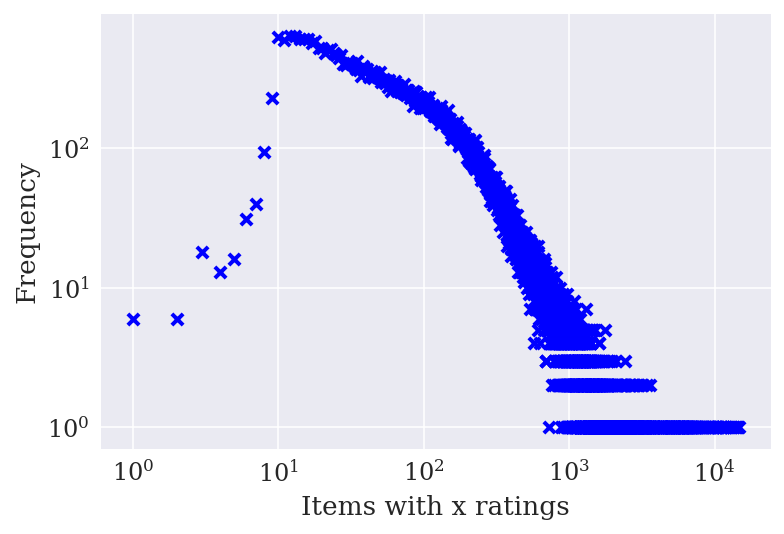

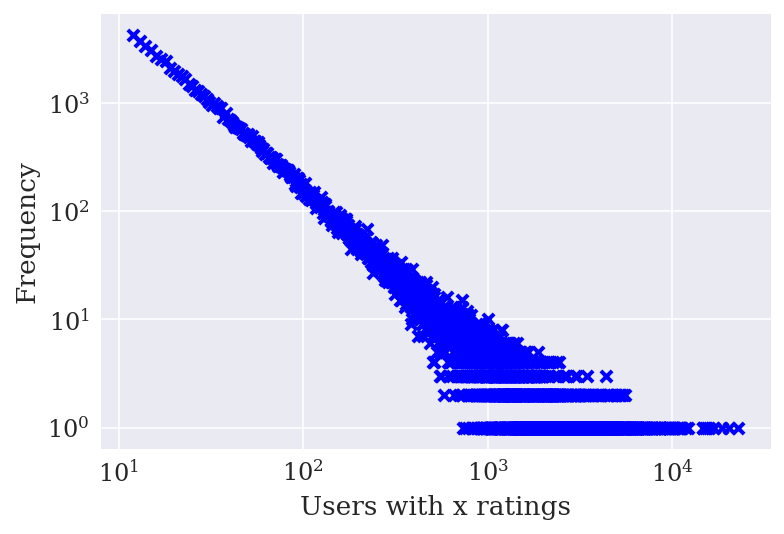

In [61]:
get_plot_distribution(item_popularity, 'Items with x ratings')
get_plot_distribution(user_activity, 'Users with x ratings')

#### Filtering users from validation set

In [63]:
print('There are unique users: %d training set, %d validation set and %d testing set' %
     (len(pd.unique(train_raw_data['userID'])), len(pd.unique(val_raw_data['userID'])), len(pd.unique(test_raw_data['userID']))))

#### Filtering items from validation set

In [65]:
print('There are unique items: %d training set, %d validation set and %d testing set' %
     (len(pd.unique(train_raw_data['pictureID'])), len(pd.unique(val_raw_data['pictureID'])), len(pd.unique(test_raw_data['pictureID']))))

### Here, we guarantee that there is no item that appears only in valiation and testing

In [66]:
train_items = train_raw_data['pictureID'].values

In [67]:
val_raw_data = val_raw_data[val_raw_data['pictureID'].isin(train_items)]

In [68]:
test_raw_data = test_raw_data[test_raw_data['pictureID'].isin(train_items)]

In [70]:
print('There are unique items: %d training set, %d validation set and %d testing set' %
     (len(pd.unique(train_raw_data['pictureID'])), len(pd.unique(val_raw_data['pictureID'])), len(pd.unique(test_raw_data['pictureID']))))

In [71]:
raw_processed_data = pd.concat([train_raw_data, val_raw_data, test_raw_data])

In [72]:
raw_processed_data.shape

(10749427, 3)

In [75]:
print train_raw_data.shape, val_raw_data.shape, test_raw_data.shape, raw_processed_data.shape
print (train_raw_data.shape[0]+val_raw_data.shape[0]+test_raw_data.shape[0] == raw_processed_data.shape[0]) # the whole
# is the sum of partitions

In [76]:
print 'Num users in:\noverall: %d\ntrain: %d\nval: %d\ntest:%d\n' % (len(pd.unique(raw_processed_data['userID'])),
                                                               len(pd.unique(train_raw_data['userID'])),
                                                               len(pd.unique(val_raw_data['userID'])),
                                                               len(pd.unique(test_raw_data['userID'])))

In [77]:
print 'Num items in:\noverall: %d\ntrain: %d\nval: %d\ntest:%d\n' % (len(pd.unique(raw_processed_data['pictureID'])),
                                                               len(pd.unique(train_raw_data['pictureID'])),
                                                               len(pd.unique(val_raw_data['pictureID'])),
                                                               len(pd.unique(test_raw_data['pictureID'])))

In [78]:
print 'Num ratings in:\noverall: %d\ntrain: %d\nval: %d\ntest:%d\n' % (raw_processed_data.shape[0],
                                                                      train_raw_data.shape[0],
                                                                      val_raw_data.shape[0],
                                                                      test_raw_data.shape[0])

### Storing user and item ids

In [79]:
raw_processed_data, user_activity, item_popularity = filter_triplets(raw_processed_data, min_items_per_user=0, min_ratings_per_item=0)

In [65]:
print train_raw_data.shape, val_raw_data.shape, test_raw_data.shape, raw_processed_data.shape
print (train_raw_data.shape[0]+val_raw_data.shape[0]+test_raw_data.shape[0] == raw_processed_data.shape[0]) # the whole
# is the sum of partitions

In [81]:
print output_dir

In [82]:
unique_user_id = user_activity.index
unique_item_id = item_popularity.index

user2id = dict((user_id, i) for (i, user_id) in enumerate(unique_user_id))
item2id = dict((item_id, i) for (i, item_id) in enumerate(unique_item_id))

os.system('mkdir -p %s' % (os.path.join(DATA_DIR, output_dir)))
with open(os.path.join(DATA_DIR, output_dir, 'unique_user_id.dat'), 'w') as f:
    for user_id in unique_user_id:
        f.write('%s\n' % user_id)

with open(os.path.join(DATA_DIR, output_dir, 'unique_item_id.dat'), 'w') as f:
    for item_id in unique_item_id:
        f.write('%s\n' % item_id)

0

### Dump processed data as user_id,item_id,timestamp format

In [86]:
def dump(data):
    user_id = map(lambda x: user2id[x], data['userID'])
    item_id = map(lambda x: item2id[x], data['pictureID'])
    data['userID'] = user_id
    data['pictureID'] = item_id
    return data[['userID', 'pictureID', 'title']]

In [87]:
train_data = dump(train_raw_data.copy())
train_data.to_csv(os.path.join(DATA_DIR, output_dir, 'train.dat'), index=False)

validation_data = dump(val_raw_data.copy())
validation_data.to_csv(os.path.join(DATA_DIR, output_dir, 'validation.dat'), index=False)

test_data = dump(test_raw_data.copy())
test_data.to_csv(os.path.join(DATA_DIR, output_dir, 'test.dat'), index=False)

## Representation of textual content (tfidf and tf: from title+plot)

### We consider the following criteria:

- concatenate title and plot
- remove stopwords
- use tf-idf to choose top 8k words as vocabulary

In [88]:
content_data.shape

(72349, 3)

In [92]:
content_data = content_data[content_data['id'].isin(pd.unique(train_raw_data['pictureID']))]

In [93]:
content_data.shape

(25767, 3)

In [94]:
content_data.head()

,description,title,id
0,Smile On Saturday @ Seasons Beauty\nHappy Eart...,Rhodies - Happy Earth Day,33390536153
2,"No Extra-Terrestrials here, just some broken ...",Alien Ship Crash Landing,33153645404
12,A &quot;scrabbled&quot; egg in the morning wit...,Scrabbled Egg,32473555623
14,I found a bag of these very small clothespins ...,7DWF- Teeny Tiny Clothespins,32691370250
20,Another image from this past weekend exploring...,Cosmic Post Office,10068538465


### reference for below functions: https://buhrmann.github.io/tfidf-analysis.html

In [95]:
def top_tfidf_feats(tfv, row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids   = np.argsort(row)[::-1][:top_n]
    top_feats  = [(features[i], row[i], tfv.idf_[i]) for i in topn_ids]
    df         = pd.DataFrame(top_feats)
    df.columns = ['word', 'tfidf', 'idf']
    return df[df['tfidf']>0]

In [96]:
def top_feats_in_doc(tfv, Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(tfv, row, features, top_n)

In [97]:
# Getting top VOCABULARY_SIZE words from plot according to tfidf
output_vocabulary_file = os.path.join(DATA_DIR, '%s/vocabulary_%s.csv' % (output_dir, DATASET_ID))
force = False # force vocabulary construction, this may take a while

vocab = list()
if force or not os.path.exists(output_vocabulary_file):

    VOCABULARY_SIZE = 8000

    tfv = TfidfVectorizer(strip_accents='unicode',
                          analyzer="word", token_pattern=r'\w{1,}',stop_words='english',
                          decode_error='replace', encoding='utf-8')
    
    description   = content_data['title'].astype(str).str.cat(content_data['description'].astype(str), sep=' ')
    tfidf_matrix  = tfv.fit_transform(description.values.astype('U'))
    feature_names = tfv.get_feature_names()
    
    result = pd.DataFrame()
    for i in range(len(description)):
        tmp = top_feats_in_doc(tfv, tfidf_matrix, feature_names,i)
        result = pd.concat([tmp, result])
        
    result = result.groupby('word', sort=False, as_index=True).max().reset_index().sort_values(['tfidf'], ascending=False)[:VOCABULARY_SIZE]

    result.to_csv(output_vocabulary_file, index=False)
    vocab = list(result['word'].values.astype(str))
    
else: # read vocabulary file
    print 'reading %s' % (output_vocabulary_file)
    with open(output_vocabulary_file, 'r') as infile:
        reader = csv.reader(infile)
        reader.next() # ignoring header
        for rows in reader:
            vocab.append(rows[0])
        
print 'Vocabulary size %s' % (len(vocab))

In [98]:
def rep_dict(doc, vectorizer, feat_names):
    tmp_doc_vec = vectorizer.transform([doc])
    result = {'%s'.encode('utf-8') % (feat_names[col]):float('%.5f' % (tmp_doc_vec[0,col])) 
              for col in tmp_doc_vec[0,:].nonzero()[1]}
    return result

In [100]:
# Getting tfidf representation of items
tfv = TfidfVectorizer(strip_accents='unicode',
                      analyzer="word", token_pattern=r'\w{1,}',stop_words='english',
                      decode_error='replace', encoding='utf-8',
                      vocabulary=vocab)
description   = content_data['title'].astype(str).str.cat(content_data['description'].astype(str), sep=' ')
tfidf_matrix  = tfv.fit_transform(description.values.astype('U'))
feature_names = tfv.get_feature_names()
content_data['tfidf_title_plot']  = description.apply(lambda x : rep_dict(x, tfv, feature_names))

In [101]:
content_data.head()

,description,title,id,tfidf_title_plot
0,Smile On Saturday @ Seasons Beauty\nHappy Eart...,Rhodies - Happy Earth Day,33390536153,"{u'beauty': 0.3152, u'smile': 0.37889, u'seaso..."
2,"No Extra-Terrestrials here, just some broken ...",Alien Ship Crash Landing,33153645404,"{u'just': 0.20408, u'shells': 0.45652, u'harbo..."
12,A &quot;scrabbled&quot; egg in the morning wit...,Scrabbled Egg,32473555623,"{u'week': 0.14652, u'quot': 0.19863, u'macro':..."
14,I found a bag of these very small clothespins ...,7DWF- Teeny Tiny Clothespins,32691370250,"{u'good': 0.16571, u'days': 0.17544, u'tiny': ..."
20,Another image from this past weekend exploring...,Cosmic Post Office,10068538465,"{u'heavy': 0.22137, u'past': 0.2043, u'clouds'..."


In [102]:
# Getting tf representation of items
cfv = CountVectorizer(strip_accents='unicode',
                      analyzer="word", token_pattern=r'\w{1,}',stop_words='english',
                      decode_error='replace', encoding='utf-8',
                      vocabulary=vocab)
description = content_data['title'].astype(str).str.cat(content_data['description'].astype(str), sep=' ')
tf_matrix  = tfv.fit_transform(description.values.astype('U'))
feature_names = tfv.get_feature_names()
content_data['tf_title_plot']  = description.apply(lambda x : rep_dict(x, cfv, feature_names))

In [103]:
content_data.head()

,description,title,id,tfidf_title_plot,tf_title_plot
0,Smile On Saturday @ Seasons Beauty\nHappy Eart...,Rhodies - Happy Earth Day,33390536153,"{u'beauty': 0.3152, u'smile': 0.37889, u'seaso...","{u'beauty': 1.0, u'seasons': 1.0, u'smile': 1...."
2,"No Extra-Terrestrials here, just some broken ...",Alien Ship Crash Landing,33153645404,"{u'just': 0.20408, u'shells': 0.45652, u'harbo...","{u'just': 1.0, u'shells': 1.0, u'harbor': 1.0,..."
12,A &quot;scrabbled&quot; egg in the morning wit...,Scrabbled Egg,32473555623,"{u'week': 0.14652, u'quot': 0.19863, u'macro':...","{u'week': 1.0, u'quot': 2.0, u'macro': 1.0, u'..."
14,I found a bag of these very small clothespins ...,7DWF- Teeny Tiny Clothespins,32691370250,"{u'good': 0.16571, u'days': 0.17544, u'tiny': ...","{u'good': 1.0, u'days': 1.0, u'tiny': 1.0, u'b..."
20,Another image from this past weekend exploring...,Cosmic Post Office,10068538465,"{u'heavy': 0.22137, u'past': 0.2043, u'clouds'...","{u'ghost': 1.0, u'past': 1.0, u'clouds': 1.0, ..."


In [104]:
# dump textual representations
content_data.to_csv(os.path.join(DATA_DIR, output_dir, 'tf_title_plot.csv'), 
                    columns=['id', 'tf_title_plot'], index=False)
content_data.to_csv(os.path.join(DATA_DIR, output_dir, 'tfidf_title_plot.csv'), 
                    columns=['id', 'tfidf_title_plot'], index=False)

## Checking if there is content for all items in train, validation, and test sets

In [105]:
a = set(valid_content_movie_ids)
b = set(pd.unique(train_raw_data['pictureID']))
c = set(pd.unique(val_raw_data['pictureID']))
d = set(pd.unique(test_raw_data['pictureID']))

In [106]:
print len(b.difference(a))
print len(c.difference(a))
print len(d.difference(a))

Ok, we have all descriptions that we need!

## After filtering, we have a dataset with these numbers:

In [109]:
num_users   = len(pd.unique(raw_processed_data['userID']))
num_items   = len(pd.unique(raw_processed_data['pictureID']))
num_ratings = raw_processed_data['title'].shape[0]
sparsity    = 1. * raw_processed_data.shape[0] / (num_users * num_items)
print '#users %s #items %s #ratings %s (sparsity: %.3f)' % (num_users, num_items, num_ratings, sparsity)

In [110]:
(num_users, num_items, num_ratings, sparsity)

(91530, 25428, 10749427, 0.004618592538524252)

In [2]:
#Done